In [1]:
# add root dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
root_dir = os.path.dirname(parent_dir)
sys.path.insert(0, root_dir)

# Imports 

In [2]:
# own imports
from imageGenerators import load_digits, load_realdata
from imageGenerators.imgGen_simple import synth_generator
from models.cyclegan_modified.cyclegan import cyclegan
import models.common_functions 
# librarys
import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from os import listdir, mkdir
import os
import numpy as np
import time
import pickle

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

# Parameters 

In [4]:
N_IMAGES = 5
EPOCHS = 4
N_TEST = 5
N_DIGITS = 5
BATCH_SIZE = 1
BUFFER_SIZE = 1000

# all images will be resized to these dimensions
#                  width, height
IMAGE_DIMENSIONS = (512, 128)
#IMAGE_DIMENSIONS = (256, 256)
GRAYSCALE = False
N_CHANNELS = 1 if GRAYSCALE else 3
#              height,              width,               channels
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], N_CHANNELS)

#CHECKPOINTPATH = Path("D:/m2/savedmodels/test")
CHECKPOINTPATH = None # dont save model

# generate synthetic images (Domain A)

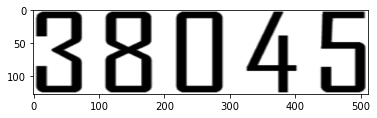

In [5]:
# path to the char74k datset
datasetPath = Path("C:/Users/andre/Desktop/m/datasets/Chars74K/English/Fnt")
# make list mapping integers to list of images of that digit: 
digitImages = load_digits.load_char74k(datasetPath)
# init imagegenerator
synthGenerator = synth_generator(digitImages)
# prepare inputdigits 
digitsTrain = np.random.randint(0,10,size=(N_IMAGES, N_DIGITS))
digitsTest = np.random.randint(0,10,size=(N_TEST, N_DIGITS))
# params to imagegenerator
margins = [20 for _ in range(0, N_DIGITS - 1)] # distances between digits
border = (2, 2, 2, 2) # padding of resultimage
height = IMAGE_DIMENSIONS[1]; width= IMAGE_DIMENSIONS[0] # dimensions to resize result to
# generate images
synthTrain = synthGenerator.generate_images(digitsTrain, margins, border, width, height)
synthTest = synthGenerator.generate_images(digitsTest, margins, border, width, height)

plt.imshow(synthTrain[0], cmap='gray')
plt.show()

# load real images (Domain B)

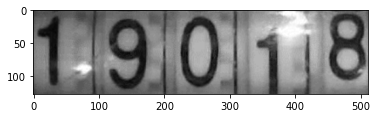

In [6]:
wmr_path = Path("C:/Users/andre/Desktop/m/datasets/SCUT-WMN DataSet/easy_samples")
real, paths_used = load_realdata.load_wmr(wmr_path, n_images=(N_IMAGES + N_TEST), resize_to=IMAGE_DIMENSIONS)
realTrain = real[0:N_IMAGES]
realTest = real[N_IMAGES:-1]

plt.imshow(realTrain[0], cmap='gray')
plt.show()

# Preprocess inputs

In [7]:
# make tf-Datasets
train_A = tf.data.Dataset.from_tensor_slices(synthTrain)
train_B = tf.data.Dataset.from_tensor_slices(realTrain)
test_A = tf.data.Dataset.from_tensor_slices(synthTest)
test_B = tf.data.Dataset.from_tensor_slices(realTest)
# define preprocessing operations
def preprocess(imageTensor):
    # reshape (h,w) -> (h,w,1)
    imageTensor = tf.reshape(imageTensor, (imageTensor.shape[0], imageTensor.shape[1], 1))
    if(not GRAYSCALE):
        # duplicate last dimension
        imageTensor = tf.repeat(imageTensor, 3, axis=-1)
    # to float
    imageTensor = tf.cast(imageTensor, tf.float32)
    # normalize
    imageTensor = (imageTensor / 127.5) - 1
    return imageTensor
# apply preprocessing, cache and batch (data already shuffled)
train_A = train_A \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
test_A = test_A \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
train_B = train_B \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
test_B = test_B \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)

# load model

In [8]:
cgModel = cyclegan(IMAGE_SHAPE, checkpoint_path=None)

No checkpointpath given, model will not be saved.


In [9]:
cgModel.gen_AtoB.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 512, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (None, 134, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 512, 64) 9472        reflection_padding2d[0][0]       
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 128, 512, 64) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
cgModel.train(train_A, train_B, test_A, n_testimages=N_TEST, epochs=EPOCHS, epochs_before_save=2)